In [1]:
import ssl
print(ssl.OPENSSL_VERSION)

OpenSSL 1.1.1s  1 Nov 2022


In [2]:
!pip install --upgrade pip

Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError("Can't connect to HTTPS URL because the SSL module is not available.")) - skipping


In [3]:
pip install stardist

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
from stardist.models import StarDist2D

# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')


There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [3]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
#matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

In [4]:
from stardist.models import StarDist2D

# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [9]:
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt
from PIL import Image

# Open the TIFF image

img_mip = sorted(glob('image.tif'))
img_mip= list(map(imread,img_mip))

img_mip_lab= sorted(glob('image_labeled.tif'))
img_mip_lab= list(map(imread,img_mip_lab))


img_tif = sorted(glob('in1-sec.tif'))
img_tif= list(map(imread,img_tif))

img_tif_lab = sorted(glob('in1-sec_lab.tif'))
img_tif_lab= list(map(imread,img_tif_lab))

#img_lab= sorted(glob('in1-sec_lab.tif'))
#img_lab= list(map(imread,img_lab))
print(len(img_mip))
print(len(img_mip_lab))

print(len(img_tif))
print(len(img_tif_lab))

1
1
1
1


In [10]:
#Random color map labels
np.random.seed(42)
lbl_cmap = random_label_cmap()

#Read input image and corresponding mask names
X_mip = sorted(glob('image.tif'))
Y_mip = sorted(glob('image_labeled.tif'))

X_tif = sorted(glob('in1-sec.tif'))
Y_tif = sorted(glob('in1-sec_lab.tif'))

import numpy as np
def slice_numpy_array(image_array):
    # Get the shape of the original array
    height, width = image_array.shape

    # Ensure that both dimensions are divisible by 16
    new_height = height - (height % 16)
    new_width = width - (width % 16)
    image_array = image_array[:new_height, :new_width]

    # Calculate the dimensions of each slice
    slice_height = new_height // 3
    slice_width = new_width // 3

    # List to store the sliced arrays
    sliced_arrays = []

    # Loop through each row and column to slice the array
    for row in range(3):
        for col in range(3):
            upper = row * slice_height
            left = col * slice_width
            lower = upper + slice_height
            right = left + slice_width

            # Ensure that both dimensions of the subarray are divisible by 16
            subarray = image_array[upper:lower, left:right]
            subarray_height, subarray_width = subarray.shape
            subarray = subarray[:subarray_height - (subarray_height % 16), :subarray_width - (subarray_width % 16)]

            # Append the subarray to the list
            sliced_arrays.append(subarray)

            # Do something with the subarray (in this case, just displaying its shape)
            print(f"Subarray at row {row + 1}, column {col + 1}: {subarray.shape}")

    return sliced_arrays

X_mip = list(map(imread,X_mip))
Y_mip = list(map(imread,Y_mip))
img_mip = slice_numpy_array(X_mip[0])
img_mip_lab = slice_numpy_array(Y_mip[0])

X_tif = list(map(imread,X_tif))
Y_tif = list(map(imread,Y_tif))
img_tif = slice_numpy_array(X_tif[0])
img_tif_lab = slice_numpy_array(Y_tif[0])

Subarray at row 1, column 1: (176, 256)
Subarray at row 1, column 2: (176, 256)
Subarray at row 1, column 3: (176, 256)
Subarray at row 2, column 1: (176, 256)
Subarray at row 2, column 2: (176, 256)
Subarray at row 2, column 3: (176, 256)
Subarray at row 3, column 1: (176, 256)
Subarray at row 3, column 2: (176, 256)
Subarray at row 3, column 3: (176, 256)
Subarray at row 1, column 1: (176, 256)
Subarray at row 1, column 2: (176, 256)
Subarray at row 1, column 3: (176, 256)
Subarray at row 2, column 1: (176, 256)
Subarray at row 2, column 2: (176, 256)
Subarray at row 2, column 3: (176, 256)
Subarray at row 3, column 1: (176, 256)
Subarray at row 3, column 2: (176, 256)
Subarray at row 3, column 3: (176, 256)
Subarray at row 1, column 1: (608, 448)
Subarray at row 1, column 2: (608, 448)
Subarray at row 1, column 3: (608, 448)
Subarray at row 2, column 1: (608, 448)
Subarray at row 2, column 2: (608, 448)
Subarray at row 2, column 3: (608, 448)
Subarray at row 3, column 1: (608, 448)


In [11]:
#Define a few augmentation methods
def random_fliprot(img, mask):
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim)))
    mask = mask.transpose(perm)
    for ax in axes:
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

100%|██████████| 9/9 [00:01<00:00,  5.57it/s]


DatasetMatching(criterion='iou', thresh=0.3, fp=4537, tp=42, fn=406, precision=0.009172308364271676, recall=0.09375, accuracy=0.008425275827482447, f1=0.01670976725681321, n_true=448, n_pred=4579, mean_true_score=0.03798223240301013, mean_matched_score=0.4051438122987747, panoptic_quality=0.006769858809050542, by_image=False)

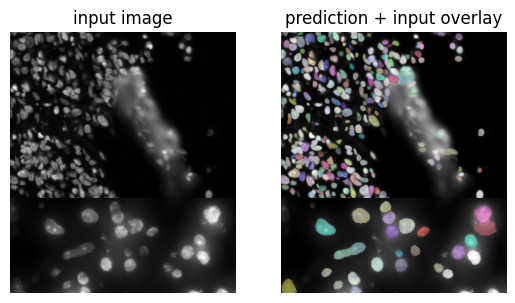

In [14]:
img_mip[0], img_mip_lab[0] = augmenter(img_mip[0], img_mip_lab[0])
labels_mip, _ = model.predict_instances(normalize(img_mip[0])) #or for loop if many images

img_tif[0], img_tif_lab[0] = augmenter(img_tif[0], img_tif_lab[0])
labels_tif, _ = model.predict_instances(normalize(img_tif[0])) #or for loop if many images


plt.subplot(1,2,1)
plt.imshow(img_mip[0], cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(labels_mip, img=img_mip[0]))
plt.axis("off")
plt.title("prediction + input overlay")


taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(img_mip_lab[0], labels_mip, thresh=t, show_progress=False) for t in tqdm(taus)]
stats[taus.index(0.3)]





plt.subplot(2,2,1)
plt.imshow(img_tif[0], cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(2,2,2)
plt.imshow(render_label(labels_tif, img=img_tif[0]))
plt.axis("off")
plt.title("prediction + input overlay")


taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(img_tif_lab[0], labels_tif, thresh=t, show_progress=False) for t in tqdm(taus)]
stats[taus.index(0.3)]

100%|██████████| 9/9 [00:02<00:00,  3.97it/s]


DatasetMatching(criterion='iou', thresh=0.3, fp=3982, tp=172, fn=308, precision=0.041405873856523834, recall=0.35833333333333334, accuracy=0.03854773644105782, f1=0.07423392317652136, n_true=480, n_pred=4154, mean_true_score=0.21979803269108136, mean_matched_score=0.6133898586727852, panoptic_quality=0.04553433564597283, by_image=False)

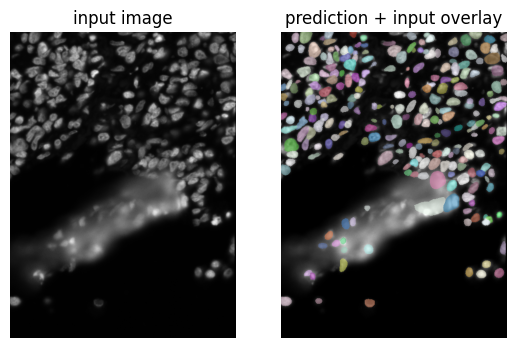

In [15]:
#img_mip[0], img_mip_lab[0] = augmenter(img_mip[0], img_mip_lab[0])
#labels_mip, _ = model.predict_instances(normalize(img_mip[0])) #or for loop if many images

img_tif[0], img_tif_lab[0] = augmenter(img_tif[0], img_tif_lab[0])
labels_tif, _ = model.predict_instances(normalize(img_tif[0])) #or for loop if many images

plt.subplot(1,2,1)
plt.imshow(img_tif[0], cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(labels_tif, img=img_tif[0]))
plt.axis("off")
plt.title("prediction + input overlay")


taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(img_tif_lab[0], labels_tif, thresh=t, show_progress=False) for t in tqdm(taus)]
stats[taus.index(0.3)]
